# A Dynnamic Bellman Problem

This problem originially comes from [Graduate Macro Theory II: Notes on Value Function Iteration, Eric Sims University of Notre Dame Lecture Note](https://www3.nd.edu/~esims1/val_fun_iter.pdf). The code was written in MATLAB but the general idea is to apply iteration to search for a fixed point convergence. This notebook is aiming to solve a Deterministic Growth Model.

$$
\begin{aligned}
V(k)=\max _{c}\left\{\frac{c^{1-\sigma}-1}{1-\sigma}+\beta V\left(k^{\prime}\right)\right\} \\
& s.t.  k^{\prime}=k^{\alpha}-c+(1-\delta) k
\end{aligned}
$$

Plug in the constraint into the value function
$$
V(k)=\max _{k^{\prime}}\left\{\frac{\left(k^{\alpha}+(1-\delta) k-k^{\prime}\right)^{1-\sigma}-1}{1-\sigma}+\beta V\left(k^{\prime}\right)\right\}
$$

The computational method is to find the fixed point k, such that if we plug in k into the value function, the  maximizer of the value function should be k itself. (i.e. $V(k)$ should converge)

$$
V^{1}(k)=\max _{k^{\prime}}\left\{\frac{\left(k^{\alpha}+(1-\delta) k-k^{\prime}\right)^{1-\sigma}-1}{1-\sigma}+\beta V^{0}\left(k^{\prime}\right)\right\}
$$
$$
V^{N}(k)=\max _{k^{\prime}}\left\{\frac{\left(k^{\alpha}+(1-\delta) k-k^{\prime}\right)^{1-\sigma}-1}{1-\sigma}+\beta V^{N-1}\left(k^{\prime}\right)\right\}
$$

And the capital stock satisfies $K_{t} = K_{t+1}$ after solving the maximization problem.
But It's worth to notice the maximization problem is usually written in convexity minimization in some optimization solvers, so we should take the minus sign of minima. In python I'm using [scipy.optimize.fminbound](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fminbound.html)

In [64]:
import numpy as np
from numpy import interp
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.optimize import fminbound

Below are the code I extracted from many different sources

concave property, more grid points at the beginning 

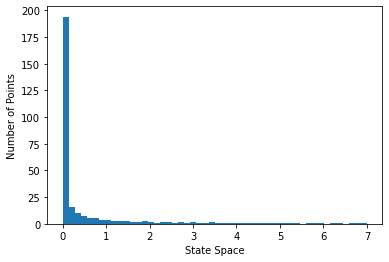

In [65]:
gridmin, gridmax, gridsize = 0.1, 7, 300
grid = np.linspace(gridmin, gridmax**1e-1, gridsize)**10
plt.hist(grid,bins=50);
plt.xlabel('State Space');
plt.ylabel('Number of Points');

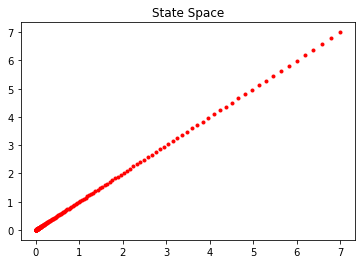

In [66]:
plt.plot(grid,grid,'r.');
plt.title('State Space');

Maxima and Maximizer (take the minus of minima)

In [67]:
def maximizer(V, a, b):
    return float(fminbound(lambda x: -V(x), a, b))
def maximum(V, a, b):
    return float(V(fminbound(lambda x: -V(x), a, b)))

Interpolation of the constraint set, define the Bellman and optimal policy operator

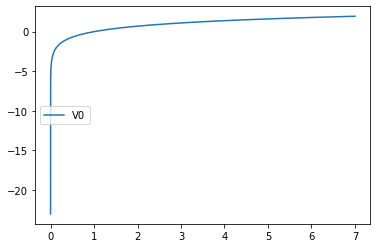

In [68]:






class LinInterp:
    "Provides linear interpolation in one dimension."

    def __init__(self, X, Y):
        """Parameters: X and Y are sequences or arrays
        containing the (x,y) interpolation points.
        """
        self.X, self.Y = X, Y

    def __call__(self, z):
        """Parameters: z is a number, sequence or array.
        This method makes an instance f of LinInterp callable,
        so f(z) returns the interpolation value(s) at z.
        """
        if isinstance(z, int) or isinstance(z, float):
            return interp ([z], self.X, self.Y)[0]
        else:
            return interp(z, self.X, self.Y)


def bellman(w):
    vals = []
    for k in grid:  #gridmin, gridmax, gridsize = 0.1, 5, 300
        kmax= k**alpha + (1-delta) * k #with no consumption 
        h = lambda kp: (((kmax - kp)**(1-sigma)-1)/(1-sigma)) + beta * w(kp)
        vals.append(maximum(h, 0, kmax))  # w is a funtion defined on the state space 
    return LinInterp(grid, vals)

def policy(w):
    vals = []
    for k in grid:
        kmax= k**alpha + (1-delta) * k
        h = lambda kp: (((kmax - kp)**(1-sigma)-1)/(1-sigma)) + beta * w(kp)
        vals.append(maximizer(h, 0, kmax))
    return LinInterp(grid, vals)





#define parameters
alpha=0.33
beta=0.95
sigma=2
delta=0.1
count=0
maxiter=3000
tol=1e-4



V0=LinInterp(grid,U(grid))
plt.figure(1)
plt.plot(grid,V0(grid), label='V'+str(count));

plt.legend(loc=6);

0 2004.1492190814 
10 0.1250068130 
20 0.0268889589 
30 0.0123642182 
40 0.0067035892 
50 0.0038901897 
60 0.0023066371 
70 0.0013766235 
80 0.0008399654 
90 0.0005113726 
100 0.0003186177 
110 0.0001776376 
120 0.0001070135 
125


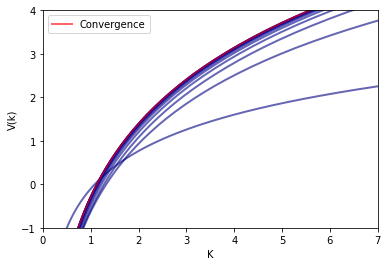

In [69]:
fig, ax = plt.subplots()
ax.set_xlim(grid.min(), grid.max())
while count<maxiter:
    V1=bellman(V0) #need to guess a V0
    err=np.max(np.abs(np.array(V1(grid))-np.array(V0(grid))))
    if np.mod(count,10)==0:
        ax.plot(grid,V1(grid), color=plt.cm.jet(count / maxiter), lw=2, alpha=0.6);
        print ('%d %2.10f ' % (count,err))
        #plot every 10 iterations 
    V0=V1
    count = count+1
    if err<tol:
        print (count)
        break
        
ax.plot(grid,V1(grid), label='Convergence', color='r', lw=2, alpha=0.6);
ax.legend(loc='upper left')
plt.xlabel('K')
plt.ylabel('V(k)') 
plt.ylim(-1, 4)
plt.draw();




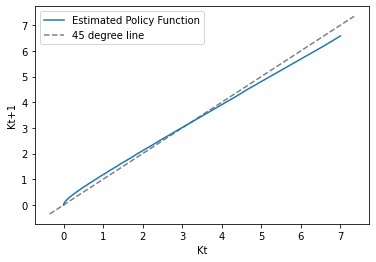

In [70]:
kt_plus1 = policy(V1)
fig, ax = plt.subplots()

ax.plot(grid, kt_plus1(grid), label='Estimated Policy Function')
ax.set_xlabel('Kt')
ax.set_ylabel('Kt+1') 
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
# a 45 degree line 
ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0,label = "45 degree line")
ax.legend(loc='upper left')




Text(0, 0.5, 'C')

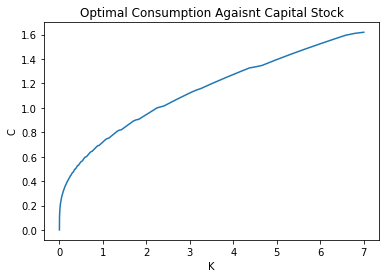

In [71]:
c = grid**alpha + (1-delta)*grid - kt_plus1(grid)
plt.plot(grid,c, label='Estimated Consumption Function')
plt.title("Optimal Consumption Agaisnt Capital Stock")
plt.xlabel('K')
plt.ylabel('C') 


Define an IVP (I set k0 = 0.5 for no valid reason)

In [74]:
T = 50
kt = []
ct = []
k0 = 0.5
kt.append(k0)
for t in range(0,T):
    k1 = kt_plus1(k0)
    c0 = k0**alpha + (1-delta)*k0 - kt_plus1(k0)
    k0 = k1
    ct.append(c0)
    kt.append(k0)

Text(0.5, 0, 'T')

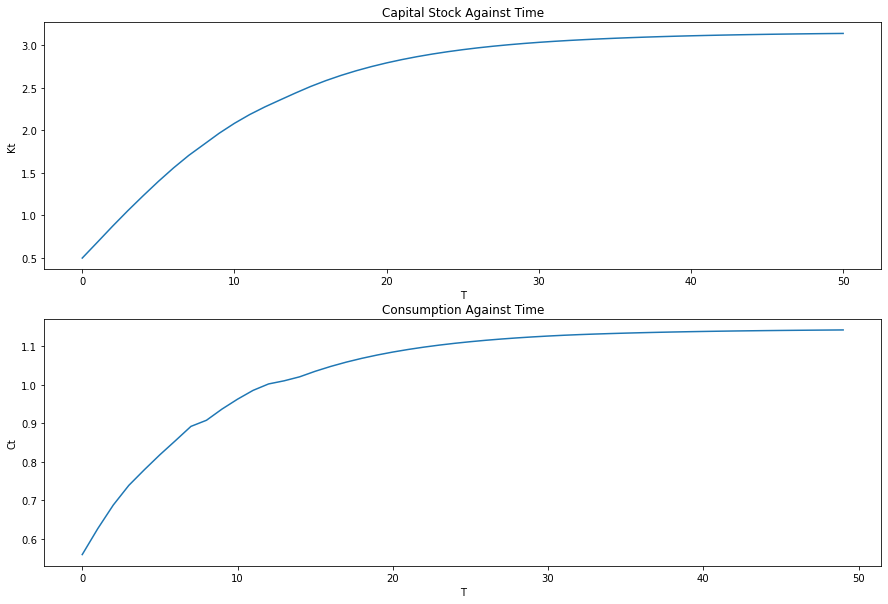

In [75]:
fig, ax = plt.subplots(2,figsize=(15,10))


ax[0].plot(kt)

ax[0].set_title("Capital Stock Against Time")
ax[0].set_ylabel('Kt')
ax[0].set_xlabel('T')

ax[1].plot(ct)
ax[1].set_title("Consumption Against Time")
ax[1].set_ylabel('Ct')
ax[1].set_xlabel('T')



## Compare with the Analytic Solution

The analytical solution given by the Euler's Equation is 
$$
k^{*}=\left(\frac{\alpha}{1 / \beta-(1-\delta)}\right)^{\frac{1}{1-\alpha}}
$$
in which we set $\sigma = 2$, $\beta = 0.95$, $\delta = 0.1$, $\alpha=0.33$

In [109]:
k_star = (alpha/((1/beta)-(1-delta)))**(1/(1-alpha))
c_star = (k_star)**alpha + (1-delta)*k_star - k_star
print(f'analytic equilibrium solution of capital is {k_star}, consumption is {c_star}')

analytic equilibrium solution of capital is 3.160860199072237, consumption is 1.145874837717893


The convergence solution, quite similar, not exactly the same even after 1000 iterations

In [77]:
kt[-1]

3.1345764075601577

In [110]:
T = 1000
kt = []
ct = []
k0 = 0.5
kt.append(k0)
for t in range(0,T):
    k1 = kt_plus1(k0)
    c0 = k0**alpha + (1-delta)*k0 - kt_plus1(k0)
    k0 = k1
    ct.append(c0)
    kt.append(k0)
print(f'steady state solution of capital is {kt[-1]}, consumption is {ct[-1]}')

steady state solution of capital is 3.1505674451593944, consumption is 1.1453313969659664


### Convergence Path

Solve for the steady state maximum value 

In [104]:
V_max = (c_star**(1-sigma)-1)/(1-sigma)/(1-beta)

In [105]:
V_max

2.546086761245494

Capital Stock Error

Text(0, 0.5, 'K')

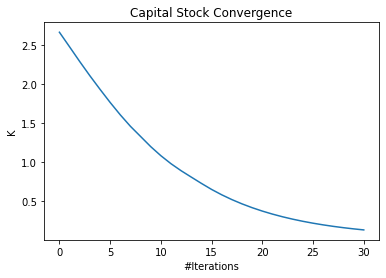

In [91]:
T = 30
kt = []
ct = []
k0 = 0.5
kt.append(k0)
for t in range(0,T):
    k1 = kt_plus1(k0)
    c0 = k0**alpha + (1-delta)*k0 - kt_plus1(k0)
    k0 = k1
    ct.append(c0)
    kt.append(k0)



err = k_star - np.asarray(kt)
plt.plot(err)
plt.title("Capital Stock Convergence")
plt.xlabel('#Iterations')
plt.ylabel('K')
